In [1]:
%matplotlib inline

In [4]:
# -*- coding: utf-8 -*-
"""
@author: Daniel

Note: make sure latest version of scipy is installed
"""
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from utils import save, load

N = 640
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


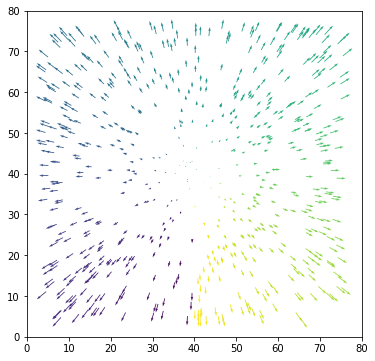

In [5]:
L = 80.0 # size of domain
rho = 0.1 # density of particles
N = int(rho*L**2) # number of particles
print("N =",N)
 
deltat = 1.0 # time step
vmax = 4/15 # max particle speed
vmax_comp = vmax/2**0.5 # max particle speed in a given component
iterations = 250 # number of time steps

def get_v(p): # function describing v as a functioning of initial position
    return (p-L/2)/(L/2)*vmax

all_pos = np.zeros(shape=(N,2,iterations))
all_v = np.zeros(shape=(N,2, iterations))
pos = np.random.uniform(L/3,2*L/3,size=(N,2)) # positions of particles
#v = np.random.uniform(-vmax_comp, vmax_comp, size=(N,2)) # orientations of particles
v = np.zeros(shape=(N,2))
for i in range(N):
    v[i, :] = get_v(pos[i, :])

fig, ax= plt.subplots(figsize=(6,6))
 
qv = ax.quiver(pos[:,0], pos[:,1], v[:,0], v[:, 1], np.arctan2(v[:,0], v[:,1]), clim=[-np.pi, np.pi])
ax.axis([0, L, 0, L])
 
def animate(i):
    if i%10==0:
        print(i)
    global pos
    
    pos += deltat*v
    # periodic boundary conditions
    pos[pos>L] -= L
    pos[pos<0] += L
    
    all_pos[:, :, i] = pos
    all_v[:, :, i] = v
 
    qv.set_offsets(pos)
    qv.set_UVC(v[:,0], v[:, 1], np.arctan2(v[:,0], v[:,1]))
    return qv,
 
anim = FuncAnimation(fig, animate, np.arange(0, iterations), interval=1, blit=True)
anim.save('burgers.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [3]:
# def save(filename, *args):
#     with open(filename, 'wb') as f:
#         for arr in args:
#             np.save(f, arr)
            
# def load(filename, nload):
#     to_load = []
#     with open(filename, 'rb') as f:
#         for i in range(nload):
#             to_load.append(np.load(f))
#     return tuple(to_load)
    
save('data_bu.npy', all_pos, all_v, deltat, [L, iterations])

### everything below here is outdated

In [5]:
# coarse-graining
res = 4 # number of points per unit length of L
width = int(res*L) # length of domain in grid points

# binned density 
binned_pts = np.zeros(shape=(width, width, iterations))
# binned rho*velocity
binned_rv = np.zeros(shape=(width, width, iterations, 2))
# binned velocity (not actually used, for illustration only)
binned_v = np.zeros(shape=(width, width, iterations, 2))

for i in range(iterations):
    for j in range(N):
        pt = all_pos[j, :, i]*res
        binned_pts[int(pt[0]), int(pt[1]), i] += 1
        binned_rv[int(pt[0]), int(pt[1]), i, :] += all_v[j, :, i]
binned_pts *= res**2
binned_rv *= res**2
for x in range(width):
    for y in range(width):
        for z in range(iterations):
            if binned_pts[x, y, z]>0:
                binned_v[x, y, z, :] = binned_rv[x, y, z, :]/binned_pts[x, y, z]

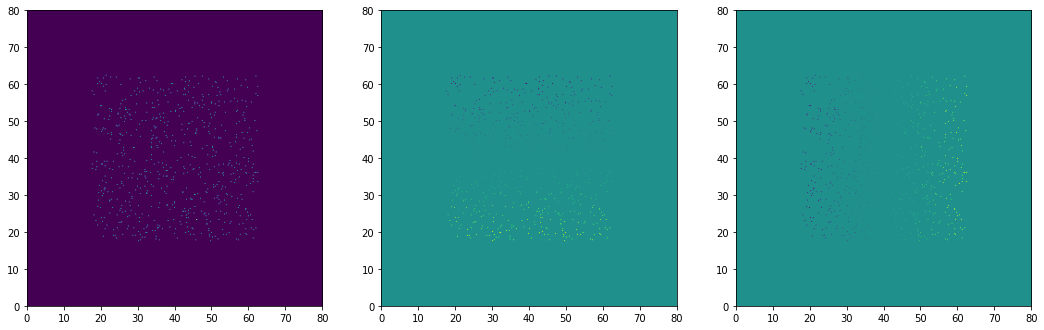

In [6]:
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, figsize=(18,6))
ax1.imshow(binned_pts[:, :, 100], extent=[0, L, 0, L])
ax2.imshow(binned_v[:, :, 100, 0], extent=[0, L, 0, L])
ax3.imshow(binned_v[:, :, 100, 1], extent=[0, L, 0, L])

In [7]:
from scipy.ndimage import gaussian_filter

sigma0 = 2

# def coarse_grain(binned, positions=None):
#     # positions - optional argument for tuning width of kernel and such
#     sigma = sigma0*res # width of convolution kernel
#     sigma_vector = np.zeros(shape=(len(binned.shape),1))
#     sigma_vector[0:2] = sigma
#     smoothed = gaussian_filter(binned, sigma_vector, mode='wrap', truncate=12)
#     return smoothed

rho = coarse_grain(binned_pts, sigma0*res)
rv = coarse_grain(binned_rv, sigma0*res)
v = np.copy(rv)

nzind = rho[:]>0
zind = rho[:]==0
v[nzind, 0] = rv[nzind, 0]/rho[nzind]
v[zind, 0] = 0
v[nzind, 1] = rv[nzind, 1]/rho[nzind]
v[zind, 1] = 0

NameError: name 'coarse_grain' is not defined

In [ ]:
fig, (ax1, ax2, ax3)= plt.subplots(ncols=3, figsize=(18,6))
ax1.imshow(rho[:, :, 100], extent=[0, L, 0, L])
ax2.imshow(rv[:, :, 100, 1], extent=[0, L, 0, L])
ax3.imshow(v[:, :, 100, 1], extent=[0, L, 0, L])

In [ ]:
# coarse-graining
res = 4 # number of points per unit length of L
width = int(res*L) # length of domain in grid points

rho_tuned = np.zeros(shape=(width, width, iterations))
rv_tuned = np.zeros(shape=(width, width, iterations, 2))
v_tuned = np.zeros(shape=(width, width, iterations, 2))
rhom = np.mean(rho)

# def gauss1d(x0, sigma, truncate=12, xmin=0, xmax=0, wrap=True):
#     offset = int(x0)
#     halfwidth = int(np.ceil(truncate*sigma))
#     if not wrap:
#         mn = np.max([offset-halfwidth, xmin])
#         mx = np.min([offset+halfwidth, xmax])
#     else:
#         mn = offset-halfwidth 
#         mx = offset+halfwidth
#     x = np.arange(mn, mx)
#     gx = np.exp(-(x-x0)**2/(2*sigma**2))
#     gx /= sum(gx) # normalize
#     return gx, mn, mx

for i in range(iterations):
    if i % 10 == 0:
        print(i)
    for j in range(N):
        pt = all_pos[j, :, i]*res
        ptx = pt[0]
        pty = pt[1]
        this_v = all_v[j, :, i]
        local_dens = rho[int(ptx), int(pty), i]
        sigma = sigma0*res
        #sigma = np.min([L/3, 2*sigma0*(local_dens/rhom)**-0.5])*res
        gx, mnx, mxx = gauss1d(ptx, sigma)
        gy, mny, mxy = gauss1d(pty, sigma)
        g = res**2*np.outer(gx, gy)
        xrng = np.array(range(mnx, mxx)) % width
        yrng = np.array(range(mny, mxy)) % width
        rho_tuned[xrng[:, np.newaxis], yrng, i] += g
        rv_tuned[xrng[:, np.newaxis], yrng, i, :] += g[:, :, np.newaxis]*this_v
        
nzind = rho_tuned[:]>0
zind = rho_tuned[:]==0
v_tuned[nzind, :] = rv_tuned[nzind, :]/rho_tuned[nzind, np.newaxis]
v_tuned[zind, :] = 0

In [ ]:
plt.imshow(v[:, :, 5, 1], interpolation="nearest", origin="lower")
plt.show()

In [ ]:
plt.imshow(v_tuned[:, :, 5, 1], interpolation="nearest", origin="lower")
plt.show()

In [ ]:
save('arrays_bu.npy', rho_tuned, v_tuned, res, deltat)

In [ ]:
np.mean(rho), np.mean(rho_tuned)

In [ ]:
np.min(gx)/np.max(gx)